# BT4016 Assignment 1
#### Written by: Bryan Chen A0204279A

## Import Packages

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from functools import reduce
from math import sqrt, exp, floor
from scipy.stats import norm
from copy import deepcopy

## Dataset Extraction

In [2]:
from pandas_datareader.data import DataReader

import requests_cache
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data_for_multiple_stocks(tickers,start_date,end_date):
    
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers:
        
        # get the data for the specific ticker
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
        #stocks.append(s.rename(mapper={'Adj Close': ticker}, axis=1)[ticker])
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        
        # add it to the dictionary
        stocks[ticker] = s
    # return the dictionary
    #return pd.concat(stocks, axis=1)
    return stocks

In [3]:
# Import dataset 

# Portfolio - 200 AAPL, 1000 DAL, 1000 CCL
tickers = ['AAPL','DAL','CCL']
portfolio =  get_data_for_multiple_stocks(tickers, start_date='2019-01-01',end_date= '2020-12-31')


Apple = portfolio['AAPL'].reset_index()
Delta = portfolio['DAL'].reset_index()
Carnival = portfolio['CCL'].reset_index()

# Make Date to date type
Apple['Date'] = Apple['Date'].apply(str)
Apple['Date'] = pd.to_datetime(Apple['Date'], infer_datetime_format=True)

Delta['Date'] = Delta['Date'].apply(str)
Delta['Date'] = pd.to_datetime(Delta['Date'], infer_datetime_format=True)

Carnival['Date'] = Carnival['Date'].apply(str)
Carnival['Date'] = pd.to_datetime(Carnival['Date'], infer_datetime_format=True)

In [4]:
Carnival.head()

,Date,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
0,2018-12-31,CCL,49.369999,48.500000,48.900002,49.299999,3970700.0,46.795429,NaN,NaN,NaN
1,2019-01-02,CCL,50.099998,48.619999,48.939999,49.849998,3926800.0,47.317493,46.795429,0.011095,0.011156
2,2019-01-03,CCL,49.410000,47.330002,49.270000,47.369999,6128200.0,44.963486,47.317493,-0.051029,-0.049749
3,2019-01-04,CCL,50.419998,48.330002,48.439999,50.049999,4568300.0,47.507336,44.963486,0.055033,0.056576
4,2019-01-07,CCL,51.240002,50.330002,51.009998,50.639999,4694900.0,48.067360,47.507336,0.011719,0.011788


In [5]:
# Rename:
Apple.rename(columns={'Adj Close':'Apple_adj_close'}, inplace=True)
Delta.rename(columns={'Adj Close':'Delta_adj_close'}, inplace=True)
Carnival.rename(columns={'Adj Close':'Carnival_adj_close'}, inplace=True)

Apple.rename(columns={'log_return':'Apple_log_return'}, inplace=True)
Delta.rename(columns={'log_return':'Delta_log_return'}, inplace=True)
Carnival.rename(columns={'log_return':'Carnival_log_return'}, inplace=True)

In [6]:
# Create a new dataset with log-returns of 3 stocks
dfs = [Apple, Delta, Carnival]
Stock_return = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
Stock_return = Stock_return[['Date','Apple_adj_close','Delta_adj_close','Carnival_adj_close','Apple_log_return','Delta_log_return','Carnival_log_return']]
Stock_return.dropna(inplace=True)

In [7]:
Apple_share = 200 # Number of Apple shares in our portfolio
Delta_share = 1000 # Number of Delta shares in our portfolio
Carnival_share = 1000 # Number of Carnival shares in our portfolio

Stock_return['Portfolio Value'] = Apple_share * Stock_return['Apple_adj_close'] + Delta_share * Stock_return['Delta_adj_close'] + Carnival_share * Stock_return['Carnival_adj_close']
Stock_return["Portfolio Prev Value"] = Stock_return["Portfolio Value"].shift(1)
Stock_return["Portfolio log_return"] = np.log(Stock_return['Portfolio Value']/Stock_return["Portfolio Prev Value"])
Stock_return.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return
1,2019-01-02,38.382229,48.430889,47.317493,0.001141,0.003800,0.011095,103424.828339,NaN,NaN
2,2019-01-03,34.559078,44.099281,44.963486,-0.104924,-0.093694,-0.051029,95974.582672,103424.828339,-0.074762
3,2019-01-04,36.034370,46.207077,47.507336,0.041803,0.046689,0.055033,100921.286774,95974.582672,0.050257
4,2019-01-07,35.954170,46.265083,48.067360,-0.002228,0.001255,0.011719,101523.277283,100921.286774,0.005947
5,2019-01-08,36.639565,45.897671,49.263348,0.018884,-0.007973,0.024577,102488.931274,101523.277283,0.009467


## Question 1
##### Using historical simulation approach to calculate the 1% daily VaR and ES of the percentage return (not value) of your portfolio of three stocks using python. The sample period is 250 trading days before your focal trading day of VaR, inclusive of the day itself, since we are measuring VaR at close of day. Please use a loop to calculate the 1-day VaR and ES from December 31st 2019 to December 30th 2020. Plot and show the graph clearly, labelling your axes.

In [8]:
start_date='2019-12-31'
end_date='2020-12-30'

focalHS_dataset = Stock_return.loc[(Stock_return['Date'] >= start_date) & (Stock_return['Date'] <= end_date)]

In [9]:
focalHS_dataset.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,122810.954285,123072.428894,-0.002127
253,2020-01-02,74.096443,58.634808,50.718056,0.022560,0.009530,0.009399,124172.151947,122810.954285,0.011023
254,2020-01-03,73.376083,57.661533,49.314434,-0.009769,-0.016738,-0.028065,121651.184082,124172.151947,-0.020511
255,2020-01-06,73.960770,57.264275,47.821857,0.007937,-0.006913,-0.030734,119878.285980,121651.184082,-0.014681
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,119907.328033,119878.285980,0.000242


#### VaR and ES Calculation

In [10]:
alpha = 0.01

#Value_at_end_of_today_col = []
#VaR_todayHS_col = []
VaR_HS_col = []
ES_HS_col = []

for i in focalHS_dataset['Date']:
    sample_dataset = Stock_return.loc[(Stock_return['Date'] <= i)].tail(250)

    log_returns = sample_dataset['Portfolio log_return']
    
    # Calculate VaR
    quantiles = log_returns.quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    
    VaR_HS = 1-exp(quantiles[0.01])

    VaR_HS_col.append(VaR_HS)

    # Calculate ES
    sorted_log_returns = sorted(log_returns)

    n = len(sorted_log_returns)

    cutoff_rt_index = floor(n*alpha+1) - 1

    sum_rt = sum(sorted_log_returns[:cutoff_rt_index])

    ES = sum_rt/len(sorted_log_returns[:cutoff_rt_index])

    ES_HS = 1-np.exp(ES) 

    ES_HS_col.append(ES_HS)

In [11]:
focalHS_dataset['VaR_HS'] = VaR_HS_col
focalHS_dataset['ES_HS'] = ES_HS_col

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
focalHS_dataset.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return,VaR_HS,ES_HS
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,122810.954285,123072.428894,-0.002127,0.035902,0.039584
253,2020-01-02,74.096443,58.634808,50.718056,0.022560,0.009530,0.009399,124172.151947,122810.954285,0.011023,0.035902,0.039584
254,2020-01-03,73.376083,57.661533,49.314434,-0.009769,-0.016738,-0.028065,121651.184082,124172.151947,-0.020511,0.035902,0.039584
255,2020-01-06,73.960770,57.264275,47.821857,0.007937,-0.006913,-0.030734,119878.285980,121651.184082,-0.014681,0.035902,0.039584
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,119907.328033,119878.285980,0.000242,0.035902,0.039584


#### Plot Results

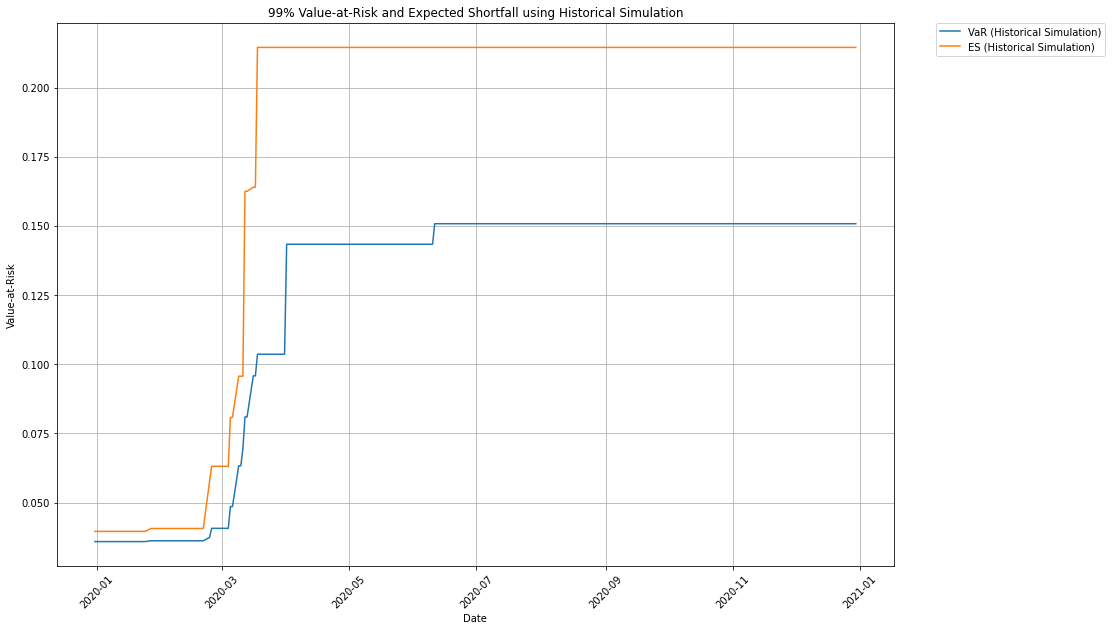

In [13]:
plt.figure(figsize=(15,10))
plt.plot(focalHS_dataset['Date'], focalHS_dataset['VaR_HS'], label='VaR (Historical Simulation)')
plt.plot(focalHS_dataset['Date'], focalHS_dataset['ES_HS'], label='ES (Historical Simulation)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value-at-Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('99% Value-at-Risk and Expected Shortfall using Historical Simulation')
plt.show()

## Question 2
##### Using parametric approach with normality distributional assumption. We assume ln(St+1/St) is normally distributed. Please repeat Q1 with the same requirements. Specifically, for Q2, we calculate portfolio variance as w’Cw, where C is the covariance matrix, as shown in the tutorial.

In [14]:
start_date='2019-12-31'
end_date='2020-12-30'

focal_dataset = Stock_return.loc[(Stock_return['Date'] >= start_date) & (Stock_return['Date'] <= end_date)]

#### VaR and ES Calculation

In [15]:
VaR_para_col = []
ES_para_col = []
alpha = 0.01

for i in focal_dataset['Date']:
    sample_dataset = Stock_return.loc[(Stock_return['Date'] <= i)].tail(250)
    
    initial_day = sample_dataset.iloc[-1]
    
    weights = np.array([Apple_share * initial_day['Apple_adj_close']/initial_day['Portfolio Value'], Delta_share * initial_day['Delta_adj_close']/initial_day['Portfolio Value'], Carnival_share * initial_day['Carnival_adj_close']/initial_day['Portfolio Value']])

    mean_stock_return = sample_dataset[['Apple_log_return','Delta_log_return','Carnival_log_return']].mean()

    returns =  np.exp(mean_stock_return.values) -1

    mean_return = np.dot(weights,returns)
    mean_log_return = np.log(1 + mean_return)
    weighted_mean = mean_log_return

    # Calculate variance-covariance matrix of 3 stocks
    mat_df = sample_dataset[['Apple_log_return','Delta_log_return','Carnival_log_return']].values

    #this will be the covariance matrix of log returns
    vcv = np.cov(mat_df.T) 

    #you need to convert it to percentage returns to perform weighting
    vcv_perc = np.exp(vcv)-1
    
    # Calculate variance of this portfolio
    variance_perc = np.dot(weights, np.dot(vcv_perc, weights))

    variance = np.log(variance_perc+1)

    volatility = sqrt(variance)
    z_alpha = norm.ppf(alpha, loc=0, scale=1)

    VaR_para = 1-np.exp(weighted_mean + volatility*z_alpha)
    VaR_para_col.append(VaR_para)

    # Calculate expected shortfall
    ES = weighted_mean+volatility*norm.pdf(norm.ppf(1-alpha, loc=0, scale=1), loc=0, scale=1)/alpha #loss function
    ES_para = 1 - np.exp(-ES)
    ES_para_col.append(ES_para)

In [16]:
focal_dataset['VaR_para'] = VaR_para_col
focal_dataset['ES_para'] = ES_para_col

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
focal_dataset.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return,VaR_para,ES_para
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,122810.954285,123072.428894,-0.002127,0.026816,0.032847
253,2020-01-02,74.096443,58.634808,50.718056,0.022560,0.009530,0.009399,124172.151947,122810.954285,0.011023,0.026095,0.031713
254,2020-01-03,73.376083,57.661533,49.314434,-0.009769,-0.016738,-0.028065,121651.184082,124172.151947,-0.020511,0.026330,0.031778
255,2020-01-06,73.960770,57.264275,47.821857,0.007937,-0.006913,-0.030734,119878.285980,121651.184082,-0.014681,0.026418,0.031710
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,119907.328033,119878.285980,0.000242,0.026425,0.031609


#### Plot Results

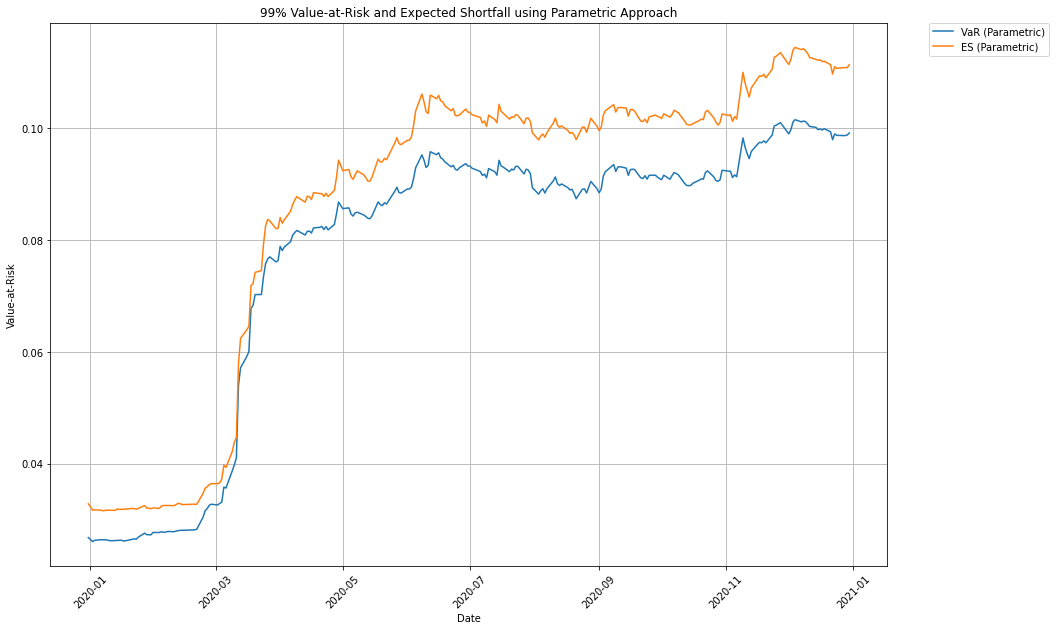

In [18]:
plt.figure(figsize=(15,10))
plt.plot(focal_dataset['Date'], focal_dataset['VaR_para'], label='VaR (Parametric)')
plt.plot(focal_dataset['Date'], focal_dataset['ES_para'], label='ES (Parametric)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value-at-Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('99% Value-at-Risk and Expected Shortfall using Parametric Approach')
plt.show()

## Question 3
##### Using the parameters identified in Q2 and the Monte Carlo simulation method to estimate 1% VaR (not need to estimate ES in this question Q3). Please repeat Q2 with the same requirements. In this question, we assume the value of your portfolio follows the Geometric Brownian Motion below. Equivalently, this implies the ln(St+1/St) return is normally distributed. For simplicity, for Q3 you should calculate portfolio variance as the standard deviation of log returns from the portfolio value for this question, treating the portfolio as one asset.

In [19]:
start_date='2019-12-31'
end_date='2020-12-30'

focalMC_dataset = Stock_return.loc[(Stock_return['Date'] >= start_date) & (Stock_return['Date'] <= end_date)]

In [20]:
focalMC_dataset.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,122810.954285,123072.428894,-0.002127
253,2020-01-02,74.096443,58.634808,50.718056,0.022560,0.009530,0.009399,124172.151947,122810.954285,0.011023
254,2020-01-03,73.376083,57.661533,49.314434,-0.009769,-0.016738,-0.028065,121651.184082,124172.151947,-0.020511
255,2020-01-06,73.960770,57.264275,47.821857,0.007937,-0.006913,-0.030734,119878.285980,121651.184082,-0.014681
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,119907.328033,119878.285980,0.000242


#### VaR Calculation

In [21]:
np.random.seed(12345) #must set to exactly 12345, PLEASE USE THIS SEED FOR THE ASSIGNMENT
VaR_MC_col = []
alpha = 0.01

for i in focalMC_dataset['Date']:
    sample_dataset = Stock_return.loc[(Stock_return['Date'] <= i)].tail(250)

    mu = sample_dataset["Portfolio log_return"].mean()
    sterr = sample_dataset["Portfolio log_return"].std()
    
    T=1

    #we estimate mu for the GBM with mu = mu+1/2 variance
    mu = (mu+((sterr**2)/2))

    new_mu = (mu-(sterr**2)/2)*T

    new_sterr = sterr*sqrt(T)

    N_simulations = 10000 # Number of Monte Carlo simulations
    log_returns = np.random.normal(loc=new_mu, scale=new_sterr, size=N_simulations)

    # Sort log_returns from low->high and find the cutoff value
    log_returns = sorted(log_returns, reverse=False)
    log_returns[int(N_simulations*alpha)]
    VaR_MC = 1-exp(log_returns[int(alpha*N_simulations)])
    VaR_MC_col.append(VaR_MC)

In [22]:
focalMC_dataset['VaR_MC'] = VaR_MC_col

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
focalMC_dataset.head()

,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return,VaR_MC
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,122810.954285,123072.428894,-0.002127,0.027483
253,2020-01-02,74.096443,58.634808,50.718056,0.022560,0.009530,0.009399,124172.151947,122810.954285,0.011023,0.026077
254,2020-01-03,73.376083,57.661533,49.314434,-0.009769,-0.016738,-0.028065,121651.184082,124172.151947,-0.020511,0.026186
255,2020-01-06,73.960770,57.264275,47.821857,0.007937,-0.006913,-0.030734,119878.285980,121651.184082,-0.014681,0.027133
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,119907.328033,119878.285980,0.000242,0.026839


## Plotting Results for Questions 1-3

### Plotting the VaR

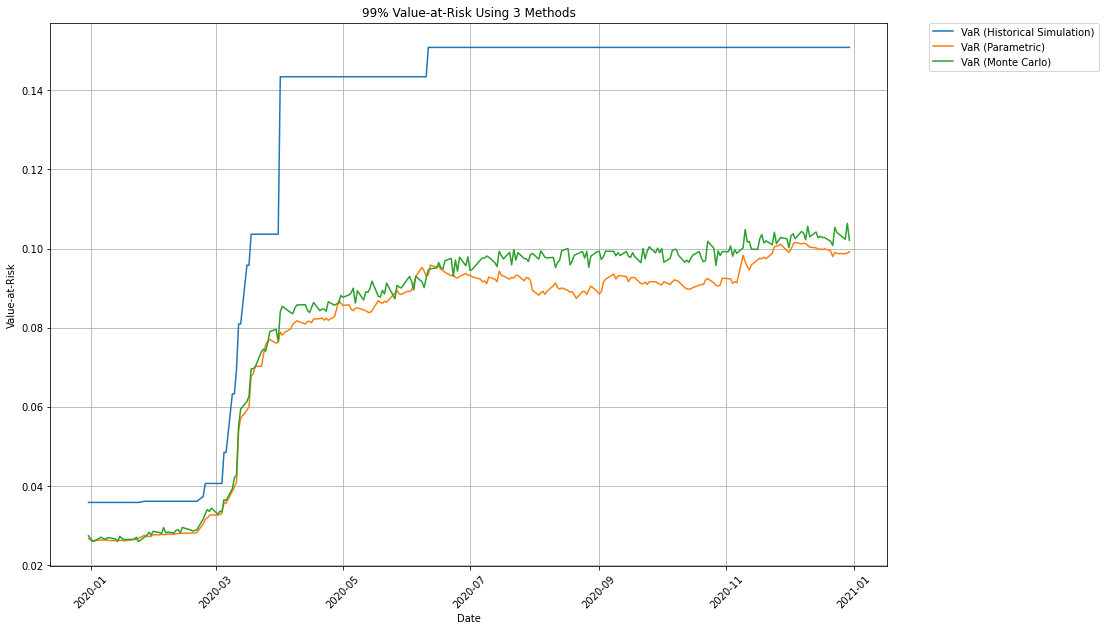

In [24]:
plt.figure(figsize=(15,10))
plt.plot(focalHS_dataset['Date'], focalHS_dataset['VaR_HS'], label='VaR (Historical Simulation)')
plt.plot(focal_dataset['Date'], focal_dataset['VaR_para'], label='VaR (Parametric)')
plt.plot(focalMC_dataset['Date'], focalMC_dataset['VaR_MC'], label='VaR (Monte Carlo)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value-at-Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('99% Value-at-Risk Using 3 Methods')
plt.show()

### Plotting the ES

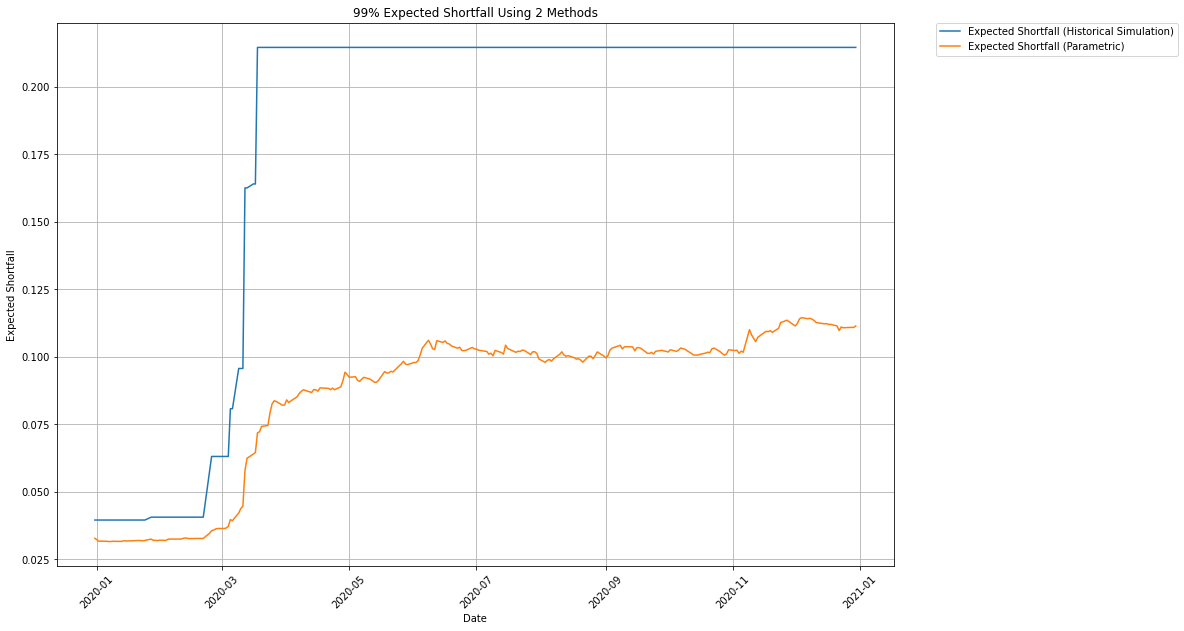

In [25]:
plt.figure(figsize=(15,10))
plt.plot(focalHS_dataset['Date'], focalHS_dataset['ES_HS'], label='Expected Shortfall (Historical Simulation)')
plt.plot(focal_dataset['Date'], focal_dataset['ES_para'], label='Expected Shortfall (Parametric)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('99% Expected Shortfall Using 2 Methods')
plt.show()

## Question 4
##### Now conduct the unconditional and independence back testing tests (Week 5 lecture and the excel) of your two 1%-VaR metrics from Q1-Q2 with the realized returns of your portfolio throughout 2020, which method between the two do you think gives the better result in 2020?

In [26]:
focalHS_dataset["Portfolio log_return_nextday"] = focalHS_dataset["Portfolio log_return"].shift(-1)
focalHS_dataset.loc[focalHS_dataset.Date == "2020-12-30", "Portfolio log_return_nextday"] = Stock_return.loc[Stock_return.Date == "2020-12-31", "Portfolio log_return"].item()
focalHS_dataset.tail()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return,VaR_HS,ES_HS,Portfolio log_return_nextday
500,2020-12-23,130.347565,40.240002,20.940001,-0.007000,0.032840,0.055474,87249.515152,85002.650070,0.026090,0.150796,0.214522,-0.004698
501,2020-12-24,131.352829,39.730000,20.840000,0.007683,-0.012755,-0.004787,86840.565491,87249.515152,-0.004698,0.150796,0.214522,0.025350
502,2020-12-28,136.050766,40.150002,21.709999,0.035141,0.010516,0.040899,89070.153809,86840.565491,0.025350,0.150796,0.214522,-0.008595
503,2020-12-29,134.239273,40.029999,21.430000,-0.013404,-0.002993,-0.012981,88307.853699,89070.153809,-0.008595,0.150796,0.214522,0.007458
504,2020-12-30,133.094650,40.560001,21.790001,-0.008563,0.013153,0.016659,88968.932343,88307.853699,0.007458,0.150796,0.214522,-0.007730


In [27]:
focal_dataset["Portfolio log_return_nextday"] = focal_dataset["Portfolio log_return"].shift(-1)
focal_dataset.loc[focal_dataset.Date == "2020-12-30", "Portfolio log_return_nextday"] = Stock_return.loc[Stock_return.Date == "2020-12-31", "Portfolio log_return"].item()
focal_dataset.tail()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Date,Apple_adj_close,Delta_adj_close,Carnival_adj_close,Apple_log_return,Delta_log_return,Carnival_log_return,Portfolio Value,Portfolio Prev Value,Portfolio log_return,VaR_para,ES_para,Portfolio log_return_nextday
500,2020-12-23,130.347565,40.240002,20.940001,-0.007000,0.032840,0.055474,87249.515152,85002.650070,0.026090,0.099030,0.111041,-0.004698
501,2020-12-24,131.352829,39.730000,20.840000,0.007683,-0.012755,-0.004787,86840.565491,87249.515152,-0.004698,0.098764,0.110754,0.025350
502,2020-12-28,136.050766,40.150002,21.709999,0.035141,0.010516,0.040899,89070.153809,86840.565491,0.025350,0.098714,0.110900,-0.008595
503,2020-12-29,134.239273,40.029999,21.430000,-0.013404,-0.002993,-0.012981,88307.853699,89070.153809,-0.008595,0.098832,0.110858,0.007458
504,2020-12-30,133.094650,40.560001,21.790001,-0.008563,0.013153,0.016659,88968.932343,88307.853699,0.007458,0.099191,0.111410,-0.007730


### Method 1: Conditional test (Bernoulli Test)

#### Historical Simulation

In [28]:
observations = len(focalHS_dataset)
observations

253

In [29]:
# Use equations to get p value of 99% VaR
from scipy.stats import binom

backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
failures = len(focalHS_dataset[-focalHS_dataset['VaR_HS']>(np.exp(focalHS_dataset['Portfolio log_return_nextday'])-1)])

observed_level = 1 - failures/observations
expected = observations*0.01
ratio = failures/expected

z_score = (failures-expected)/sqrt(expected*0.99)
p_VaR_99 = 1-binom.cdf(failures-1, observations, 0.01)
print("P-value of Historical Simulation VaR 99%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

P-value of Historical Simulation VaR 99%:  0.0002750336255739061
Reject null hypothesis


#### Parametric

In [30]:
observations = len(focal_dataset)
observations

253

In [31]:
# Use equations to get p value of 95% VaR
from scipy.stats import binom

backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
failures = len(focal_dataset[-focal_dataset['VaR_para']>(np.exp(focal_dataset['Portfolio log_return_nextday'])-1)])

observed_level = 1 - failures/observations
expected = observations*0.01
ratio = failures/expected

p_VaR_99 = 1-binom.cdf(failures-1, observations, 0.01)
print("P-value of Parametric VaR 99%%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

P-value of Parametric VaR 99%%:  1.2425909190483253e-09
Reject null hypothesis


### Method 2: Independence test (Z-score Test)

#### Historical Simulation

In [32]:
# Independence test of VaR 95%
backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
hs = deepcopy(focalHS_dataset)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
hs['ind_t'] = hs.apply(lambda row: 1 if -row['VaR_HS']>(np.exp(row['Portfolio log_return_nextday'])-1) else 0, axis=1)
hs['ind_t1'] = hs['ind_t'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
hs['ind_00'] = hs.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
hs['ind_10'] = hs.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
hs['ind_01'] = hs.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
hs['ind_11'] = hs.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

# Drop missing values
hs.dropna(inplace=True)

# 'N00' — Number of periods with no failures followed by a period with no failures (0 -> 0)
# 'N10' — Number of periods with failures followed by a period with no failures (1 -> 0)
# 'N01' — Number of periods with no failures followed by a period with failures (0 -> 1)
# 'N11' — Number of periods with failures followed by a period with failures (1 -> 1)
N00, N10, N01, N11 = hs[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)

# N - number of periods
# N1 - number of failures
# N0 - number of no failures
N = sum((N00, N10, N01, N11))
N1 = N01 + N11
N0 = N00 + N10

# p = probability of having a failure on period t
p = N1/N

# p01 = Probability of having a failure on period t, given that there was no failure on period t–1
# p11 = Probability of having a failure on period t, given that there was a failure on period t–1
p01 = N01/N0
p11 = N11/N1

# calculate z-score
z_score = (p11 - p01)/sqrt(p*(1-p)*((1/N1)+(1/N0)))

p_VaR_99 = 1-norm.cdf(z_score, 0, 1)
print("z score: ", z_score)
print("P-value of VaR 99%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  2.650124453727507
P-value of VaR 99%:  0.004023106264085197
Reject null hypothesis


#### Parametric

In [33]:
# Independence test of VaR 95%
backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
para = deepcopy(focal_dataset)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
para['ind_t'] = para.apply(lambda row: 1 if -row['VaR_para']>(np.exp(row['Portfolio log_return_nextday'])-1) else 0, axis=1)
para['ind_t1'] = para['ind_t'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
para['ind_00'] = para.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
para['ind_10'] = para.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
para['ind_01'] = para.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
para['ind_11'] = para.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)


# 'N00' — Number of periods with no failures followed by a period with no failures (0 -> 0)
# 'N10' — Number of periods with failures followed by a period with no failures (1 -> 0)
# 'N01' — Number of periods with no failures followed by a period with failures (0 -> 1)
# 'N11' — Number of periods with failures followed by a period with failures (1 -> 1)
N00, N10, N01, N11 = para[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)

# N - number of periods
# N1 - number of failures
# N0 - number of no failures
N = sum((N00, N10, N01, N11))
N1 = N01 + N11
N0 = N00 + N10

# p01 = Probability of having a failure on period t, given that there was no failure on period t–1
# p11 = Probability of having a failure on period t, given that there was a failure on period t–1
p01 = N01/N0
p11 = N11/N1

# p = probability of having a failure on period t
p = N1/N

# calculate z-score
z_score = (p11 - p01)/sqrt(p*(1-p)*((1/N1)+(1/N0)))

p_VaR_99 = 1-norm.cdf(z_score, 0, 1)
print("z score: ", z_score)
print("P-value of VaR 99%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  5.861051089592396
P-value of VaR 99%:  2.2997321824647088e-09
Reject null hypothesis


### Evaluation

#### Perfom EDA

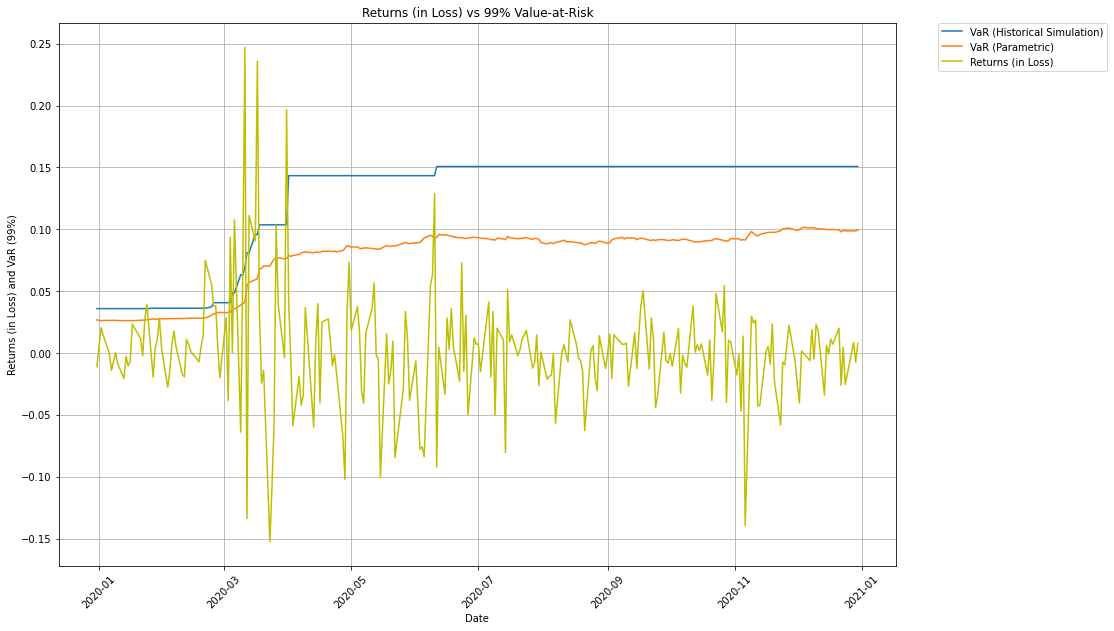

In [34]:
# Plot: Returns vs VaR 99% for Historical Simulation
plt.figure(figsize=(15,10))
plt.plot(focalHS_dataset['Date'], focalHS_dataset['VaR_HS'], label='VaR (Historical Simulation)')
plt.plot(focal_dataset['Date'], focal_dataset['VaR_para'], label='VaR (Parametric)')
plt.plot(focalHS_dataset['Date'], -focalHS_dataset['Portfolio log_return_nextday'], 'y-', label='Returns (in Loss)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR (99%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 99% Value-at-Risk')
plt.show()

In [35]:
# Statistical tests for VaR backtesting
# Compare the different test results for the normal distribution approach at the 95% and 99% VaR levels.
observations = len(focalHS_dataset)
failures = len(focalHS_dataset[-focalHS_dataset['VaR_HS']>(np.exp(focalHS_dataset['Portfolio log_return_nextday'])-1)])
observed_level = 1 - failures/observations
expected = observations*0.01

print("Historical Simulation VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

Historical Simulation VaR 99%
VaR level: 0.99
Observed level: 0.9604743083003953
Observations: 253
Failures: 10
Expected: 2.5300000000000002


In [36]:
# Statistical tests for VaR backtesting
# Compare the different test results for the normal distribution approach at the 95% and 99% VaR levels.
observations = len(focal_dataset)
failures = len(focal_dataset[-focal_dataset['VaR_para']>(np.exp(focal_dataset['Portfolio log_return_nextday'])-1)])
observed_level = 1 - failures/observations
expected = observations*0.01

print("Parametric VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

Parametric VaR 99%
VaR level: 0.99
Observed level: 0.9328063241106719
Observations: 253
Failures: 17
Expected: 2.5300000000000002


Text(0.5, 1.0, 'Distribution of Returns')

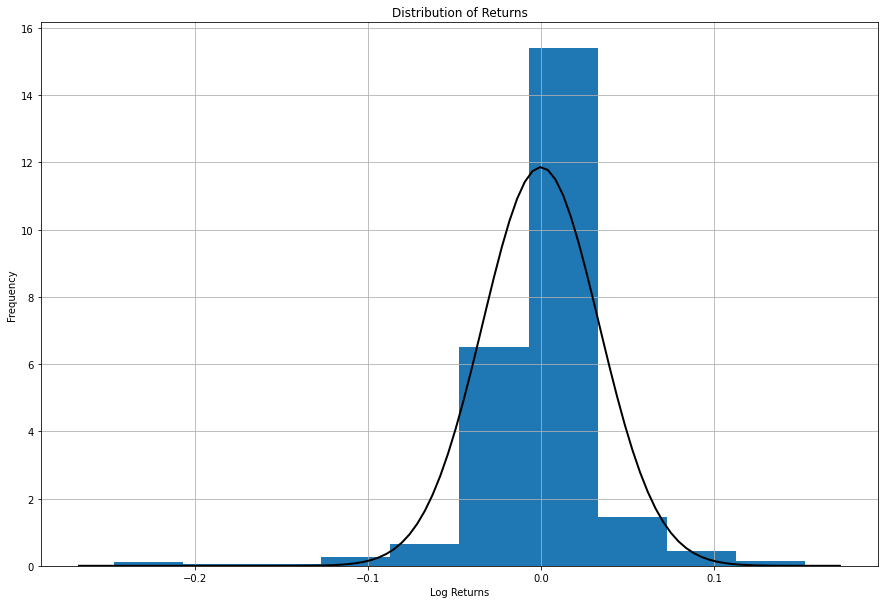

In [37]:
plt.figure(figsize=(15,10))

data = Stock_return['Portfolio log_return']
data = data.dropna()
mu, std = norm.fit(data)

plt.hist(data, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.grid(True)
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')


### Answer: The historical method is better
By comparing the 2 VaR methods using the plot "Returns (in Loss) vs 99% Value-at-Risk", we can observe that the parametric method lags the historical method and the peak is also lower. 

Looking at the statistical tests, the number of failures for the historical method is also closer to the expected number of failures compared to the parametric method (10 and 17 respectively).

Furthermore, the parametric method assumes a normal distribution, however from the histogram, we can observe that the distribution skews right and is not normal, which means we could be underestimating risks. Moreover, the graph indicates a fat-tailed distribution, which means that we could be missing some hidden patterns in the asset price dynamics if we were to use the parametric method. 

Meanwhile, the historical VaR method puts no specific assumption on historical returns, but rather, uses the empirical discrete distribution of returns to simulate future scenarios, therefore compared to the parametric method, it can capture hidden patterns and co-movements between risk factors. 

Since the historical method is more sensitive, is statistically more accurate and can capture hidden patterns better for log returns that are not normal, we can conclude that the historical method is better.

## Question 5
##### You can now freely tweak/tune one of your 3 VaR methods (in Q1-Q3) to improve your risk metric. You only need to report the result of ONE case. For example, for parametric approach, you can use other distribution that better fits the realized distribution of your portfolio. For HS approach, you can try different length of sample period, you can try imposing larger weights of recent periods (details in textbook). For simulation, you can use more complicated stochastic process. You need to explain your ONE method clearly, also provide evidence that your method works better than three VaR methods in 2020 by also running the same two back-testing methods in Q4. The grading of this part may be partially dependent on the subjective assessment of TA about the quality and quantity of your efforts in this part.

### Method Chosen: Exponentially Weighted Historical Simulation (EWHS)

Age-weighted Historical Simulation puts a portfolio through a series of historical scenarios with heavier weightings given to more recent events. The benefits include:
- Able to handle non-linear risks
- Does not make any assumptions about the returns distribution
- Does not need to forecast and parameters
- Less computationally intensive, intuitive and easy to implement, making it more suitable to present to senior management who may not have good technical knowledge.
- Normal historical simulation assumes equal weight to all returns of the whole period. Inconsistent with the diminishing predictability of data that are further away from the present.

In [38]:
start_date='2019-12-31'
end_date='2020-12-30'

optimize_hs = Stock_return.loc[(Stock_return['Date'] >= start_date) & (Stock_return['Date'] <= end_date)]

In [39]:
alpha = 0.01
decay = 0.98

VaR_HS_col = []

for i in optimize_hs['Date']:
    sample_dataset = Stock_return.loc[(Stock_return['Date'] <= i)].tail(250)
    k = len(sample_dataset)

    periods = list(range(1,251))
    periods.reverse()
    sample_dataset['periods_ago'] = periods

    sample_dataset['weight'] = (decay**(sample_dataset['periods_ago']-1) * (1-decay))/(1-decay**k)
        
    sorted_sample = sample_dataset.sort_values(by='Portfolio log_return')
    sorted_sample['cumulative'] = sorted_sample['weight'].cumsum()
    sorted_sample = sorted_sample.reset_index().drop(columns=['index'])

    if sorted_sample.cumulative.head(1).item() > alpha:
        l_idx = 0
        u_idx = 0
    else:
        l_idx = sorted_sample[sorted_sample.cumulative <= alpha]['Portfolio log_return'].idxmax()
        u_idx = l_idx + 1

    X = sorted_sample.loc[l_idx:u_idx, 'cumulative'].values
    Y = sorted_sample.loc[l_idx:u_idx, 'Portfolio log_return'].values

    average = Y.mean()
        
    # Calculate VaR
    VaR_HS = 1-exp(average)
    VaR_HS_col.append(VaR_HS)


In [40]:
optimize_hs['VaR_HS'] = VaR_HS_col

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


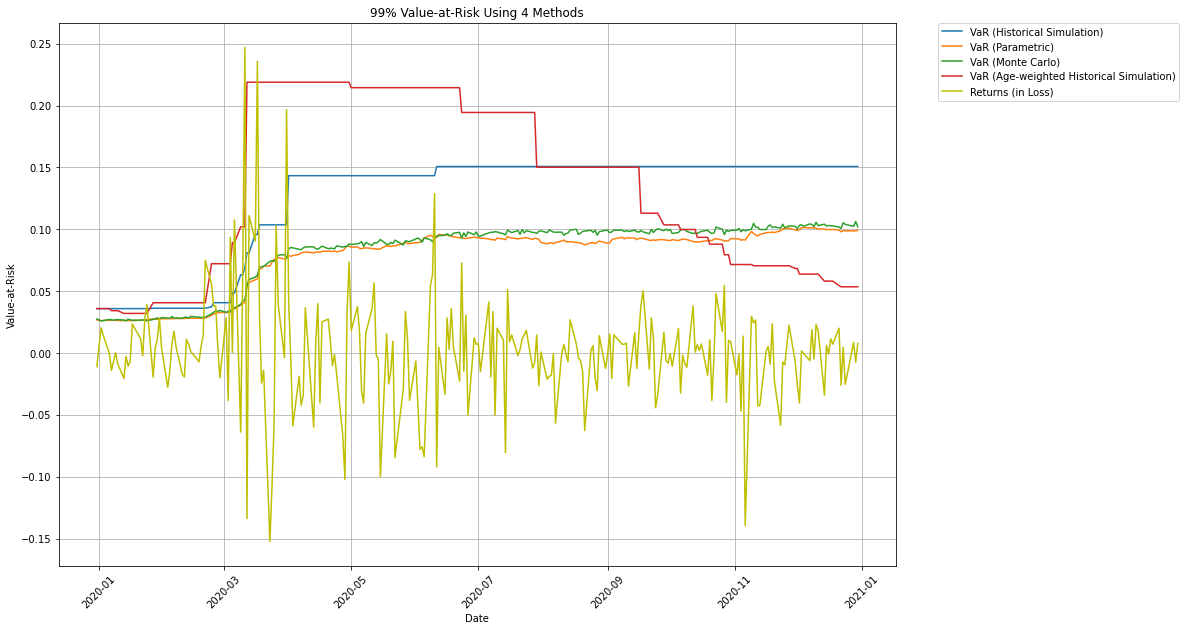

In [41]:
plt.figure(figsize=(15,10))
plt.plot(focalHS_dataset['Date'], focalHS_dataset['VaR_HS'], label='VaR (Historical Simulation)')
plt.plot(focal_dataset['Date'], focal_dataset['VaR_para'], label='VaR (Parametric)')
plt.plot(focalMC_dataset['Date'], focalMC_dataset['VaR_MC'], label='VaR (Monte Carlo)')
plt.plot(optimize_hs['Date'], optimize_hs['VaR_HS'], label='VaR (Age-weighted Historical Simulation)')
plt.plot(focalHS_dataset['Date'], -focalHS_dataset['Portfolio log_return_nextday'], 'y-', label='Returns (in Loss)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value-at-Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('99% Value-at-Risk Using 4 Methods')
plt.show()

In [42]:
optimize_hs["Portfolio log_return_nextday"] = optimize_hs["Portfolio log_return"].shift(-1)
optimize_hs.loc[optimize_hs.Date == "2020-12-30", "Portfolio log_return_nextday"] = Stock_return.loc[Stock_return.Date == "2020-12-31", "Portfolio log_return"].item()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [43]:
# Statistical tests for VaR backtesting
# Compare the different test results for the normal distribution approach at the 95% and 99% VaR levels.
observations = len(optimize_hs)
failures = len(optimize_hs[-optimize_hs['VaR_HS']>(np.exp(optimize_hs['Portfolio log_return_nextday'])-1)])
observed_level = 1 - failures/observations
expected = observations*0.01

print("Historical Simulation VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

Historical Simulation VaR 99%
VaR level: 0.99
Observed level: 0.9802371541501976
Observations: 253
Failures: 5
Expected: 2.5300000000000002


In [44]:
# Use equations to get p value of 99% VaR
from scipy.stats import binom

backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
failures = len(optimize_hs[-optimize_hs['VaR_HS']>(np.exp(optimize_hs['Portfolio log_return_nextday'])-1)])

observed_level = 1 - failures/observations
expected = observations*0.01
ratio = failures/expected

p_VaR_99 = 1-binom.cdf(failures-1, observations, 0.01)
print("P-value of Historical Simulation VaR 99%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

P-value of Historical Simulation VaR 99%:  0.11185872560184473
Not enough evidence to reject null 0.025 backtesting significance level under normal distribution 


In [45]:
# Independence test of VaR 95%
backtesting_alpha = 0.05/2 #backtesting confidence interval for two-tailed test
hs = deepcopy(optimize_hs)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
hs['ind_t'] = hs.apply(lambda row: 1 if -row['VaR_HS']>(np.exp(row['Portfolio log_return_nextday'])-1) else 0, axis=1)
hs['ind_t1'] = hs['ind_t'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
hs['ind_00'] = hs.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
hs['ind_10'] = hs.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
hs['ind_01'] = hs.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
hs['ind_11'] = hs.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

# Drop missing values
hs.dropna(inplace=True)

# 'N00' — Number of periods with no failures followed by a period with no failures (0 -> 0)
# 'N10' — Number of periods with failures followed by a period with no failures (1 -> 0)
# 'N01' — Number of periods with no failures followed by a period with failures (0 -> 1)
# 'N11' — Number of periods with failures followed by a period with failures (1 -> 1)
N00, N10, N01, N11 = hs[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)

# N - number of periods
# N1 - number of failures
# N0 - number of no failures
N = len(hs)
N1 = len(hs[hs['ind_t'] == 1])
N0 = len(hs[hs['ind_t'] == 0])

# p = probability of having a failure on period t
p = N1/N

# p01 = Probability of having a failure on period t, given that there was no failure on period t–1
# p11 = Probability of having a failure on period t, given that there was a failure on period t–1
p01 = N01/N0
p11 = N11/N1

# calculate z-score
z_score = (p11 - p01)/sqrt(p*(1-p)*((1/N1)+(1/N0)))

p_VaR_99 = 1-norm.cdf(z_score, 0, 1)
print("z score: ", z_score)
print("P-value of VaR 99%: ", p_VaR_99)
if(p_VaR_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  -0.3213463130847681
P-value of VaR 99%:  0.6260260184194575
Not enough evidence to reject null 0.025 backtesting significance level under normal distribution 
